# Summary of last lecture

In last lecture I explained some of the tools that work under the hood of our package and allow us to keep track of all numerical errors and allow us to prove some simple mathematical results with the assistance of a computer:
- Interval Arithmetic allows us to bound the range of a function on an Interval
- Interval Newton Method allows us to rigorously solve the equation $f(x)=y$ and so allows us to rigorously find the inverse values of a function
- TaylorModels allow us to compute derivatives and integrals rigorously

# Approximating the Ulam operator

In this section I will comment on the Ulam operator, its implementation and how to run the functions in our InvariantMeasures.jl package.

Given a dynamical system $T:[0,1]\to [0,1]$ the Ulam operator on a partition $P = \{I_i\}$ is a Markov chain whose transition probabilities are
$$
M(i \to j) = P(T(x)\in I_i \mid x \in I_j).
$$

This can be rewritten in the following form, if $m$ is the Lebesgue measure
$$
M(i \to j) = \frac{m(T^{-1}I_i\cap I_j)}{m(I_j)}
$$

In [1]:
import Pkg;
Pkg.rm("RigorousInvariantMeasures")
# normally you can only install the package as below; I am reworking a couple of interface issues in these 
# days, I will do a release during this week
# Pkg.add("RigorousInvariantMeasures")
Pkg.add(path = "https://github.com/JuliaDynamics/RigorousInvariantMeasures.jl/")

    Updating `~/.julia/environments/v1.7/Project.toml`
  [6103b61f] - RigorousInvariantMeasures v0.2.0 `https://github.com/JuliaDynamics/RigorousInvariantMeasures.jl#master`
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [c3fe647b] - AbstractAlgebra v0.27.2
  [621f4979] - AbstractFFTs v1.2.1
  [1520ce14] - AbstractTrees v0.4.2
  [dce04be8] - ArgCheck v2.3.0
  [7d9fca2a] - Arpack v0.5.3
  [4c555306] - ArrayLayouts v0.8.10
  [15f4f7f2] - AutoHashEquals v0.2.0
  [13072b0f] - AxisAlgorithms v1.0.1
  [198e06fe] - BangBang v0.3.36
  [9718e550] - Baselet v0.1.1
  [e2ed5e7c] - Bijections v0.1.4
  [aaaa29a8] - Clustering v0.14.2
  [da1fd8a2] - CodeTracking v1.1.0
  [b152e2b5] - CompositeTypes v0.1.2
  [a33af91c] - CompositionsBase v0.1.1
  [717857b8] - DSP v0.7.6
  [e7dc6d0d] - DataValues v0.4.13
  [244e2a9f] - DefineSingletons v0.1.2
  [5b8099bc] - DomainSets v0.5.11
  [7c1d4256] - DynamicPolynomials v0.4.5
  [7a1cc6ca] - FFTW v1.5.0
  [442a2c76] - FastGaussQuadrature v0.4.9
  [057d

In [2]:
Pkg.instantiate()

In [6]:
using RigorousInvariantMeasures

The Package has already implemented different basis types, that work out of the box:
- Ulam basis for approximation in the $L^1$ norm
- Hat Basis for approximation in the $L^{\infty}$ norm (the dynamic must be Markov and regular)

the following two basis are also partially implemented

- a spline basis for approximations in $C^1$ (the dynamic must be Markov and regular)
- a Chebyshev basis for approximations in $C^1$ (the dynamic must be Markov and regular)

Today we will be working with the Ulam approximation.

In [7]:
B = Ulam(16)

Ulam{LinRange{Float64, Int64}}(range(0.0, stop=1.0, length=17))

We will start by analizing a known map, for which it is simple to compare what the computer is doing with pen and paper computations.

In the file DynamicDefinition.jl of the package the methods that a Dynamic type has to satisfy for the package to work out of the box are stated.

At the moment, a generic Piecewise Dynamic type is defined in PwDynamicDefinition.jl, that should work in most cases.

In [8]:
?PwMap

search: PwMap norms_of_powers_from_coarser_grid



Dynamic based on a piecewise monotonic map.

The map is defined as T(x) = Ts[k](x) if x ∈ [endpoints[k], endpoints[k+1]).

`y_endpoints` (kx2 matrix) contains the result of applying Ts to the endpoints of each interval. These can be filled in automatically from `endpoints`, but sometimes they are known to higher accuracy, for instance for `x -> mod(3x, 1)` we know that it is full-branch exactly. It is assumed that the map will send its domain hull(endpoints[begin],endpoints[end]) into itself.

the array `branches` is guaranteed to satisfy branches[i].X[end]==branches[i+1].X[begin]

---

Function call, and Taylor expansion, of a PwMap. Note that this ignores discontinuities; users are free to shoot themselves in the foot and call this on a non-smooth piecewise map. No better solutions for now.


For our first example we will use an helper constructor, the 
```
mod1_dynamic(f)
```
where $f$ is a function from $[0,1]\to \mathbb{R}$, that constructs a PwMap without us worrying too much about the underlying structure. 

In [9]:
D = mod1_dynamic(x->2*x)

Piecewise-defined dynamic with 2 branches

In [10]:
import Pkg; Pkg.add("LaTeXStrings")
using Plots, LaTeXStrings

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


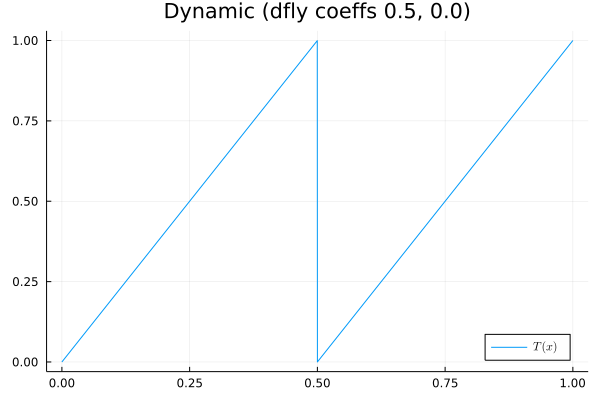

In [11]:
A, BB = dfly(strong_norm(B), aux_norm(B), D)
plot(D, title="Dynamic (dfly coeffs $(round(A, sigdigits=2)), $(round(BB, sigdigits=2)))", label=L"T(x)", legend=:bottomright)

What we are going to do is to compute preimages of an interval.

In [12]:
?RigorousInvariantMeasures.preimages

```
preimages(y, br::Branch, ylabel = 1:length(y), ϵ = 0.0)
```

Construct preimages of an increasing array y under a monotonic branch defined on X = (a, b), propagating additional labels `ylabel`

The sequence y subdivides the y-axis into semi-open intervals [y[l], y[l+1]); each of them is identified by the label `ylabel[l]`. We construct an increasing sequence  x that splits X (in the x-axis) into semi-open intervals, each of them with f([x[k], x[k+1]) ⊂ [y[l], y[l+1]) for a certain l.  We set xlabel[k] = ylabel[l], and return the pair (x, xlabel).

It is assumed that it cannot happen that f(x) < y[1].

In the simplest case where D is full-branch, the points in x are preimages of the points in y, but in the general case they can also include D.endpoints: in general, there may be a certain number of points in y that have no preimage at the beginning and the end of the sequence, because  they fall out of the range R = [f(a), f(b)]. In the worst case, no point has a preimage, because y[i] < R < y[i+1] for some  i (or vice versa with orientations), and in this case we just return the 1-element vectors x = [branch.X[1]] and xlabel = [i].

x[begin] always coincides with branch.X[1], while branch.X[2] is "the point after x[end]", and is not stored explicitly in x, for easier composing. In this way x and xlabel have the same length.

This function fills the array by using a bisection strategy to save computations: if y ∈ [a,b], then f⁻¹(y) ∈ [f⁻¹(a),f⁻¹(b)](paying attention to orientation). So we can fill v by filling in first entries `v[k+1]` with higher dyadic valuation of k.

For a dynamic with multiple branches, preimages(y, D) is simply the concatenation of x, xlabel for b in all branches. These values still form an increasing sequence that splits X into intervals, each of which is mapped into a different semi-open interval [y[k], y[k+1]).

---

```
preimages(y, D::Dynamic, ylabel = 1:length(y), ϵ = 0.0; progress = true)

Construct preimages of an increasing array y under a dynamic, propagating additional labels `ylabel`
```


The function preim is doing nothing else than computing the preimages of the endpoints of $B$, using the Interval Newton method. To show this, I will compare them side to side, when computing the preimages through the first branch.

In [13]:
v, v_labels = RigorousInvariantMeasures.preimages(B.p, D);
v

32-element Vector{Interval{Float64}}:
 [0, 0]
     [0.03125, 0.03125]
     [0.0625, 0.0625]
     [0.09375, 0.09375]
     [0.125, 0.125]
     [0.15625, 0.15625]
     [0.1875, 0.1875]
     [0.21875, 0.21875]
     [0.25, 0.25]
     [0.28125, 0.28125]
     [0.3125, 0.3125]
     [0.34375, 0.34375]
     [0.375, 0.375]
      ⋮
     [0.625, 0.625]
     [0.65625, 0.65625]
     [0.6875, 0.6875]
     [0.71875, 0.71875]
     [0.75, 0.75]
     [0.78125, 0.78125]
     [0.8125, 0.8125]
     [0.84375, 0.84375]
     [0.875, 0.875]
     [0.90625, 0.90625]
     [0.9375, 0.9375]
     [0.96875, 0.96875]

Once we have the preimages of the interval $I_i$, we can compute the intersection with the interval $I_j$.
As an example, we will compute the relative measure of $T^{-1}(I_1)$ in $I_1$

In [14]:
RigorousInvariantMeasures.relative_measure(
    (preim(D, 1, B.p[1]),preim(D, 1, B.p[2])), 
    (Interval(B.p[1]), Interval(B.p[2]))
    )

[0.5, 0.5]

As you can see, this relative measure returns an Interval, because the preimages are wide intervals. This interval contains that the true value of $M(i\to j)$. This adds an error in our computation, but this is taken care by the package.

Please remark that you do not need to do this for each entry of the matrix, the package already exports a function that does everything for you.

In [15]:
B = Ulam(256)
Q = DiscretizedOperator(B, D)

IntegralPreservingDiscretizedOperator{SparseArrays.SparseMatrixCSC{Interval{Float64}, Int64}}(sparse([1, 2, 2, 3, 4, 4, 5, 6, 6, 7  …  250, 250, 251, 252, 252, 253, 254, 254, 255, 256], [1, 1, 2, 2, 2, 3, 3, 3, 4, 4  …  253, 254, 254, 254, 255, 255, 255, 256, 256, 256], Interval{Float64}[[0.5, 0.5], [0.5, 0.5], [0, 0], [0.5, 0.5], [0.5, 0.5], [0, 0], [0.5, 0.5], [0.5, 0.5], [0, 0], [0.5, 0.5]  …  [0.5, 0.5], [0, 0], [0.5, 0.5], [0.5, 0.5], [0, 0], [0.5, 0.5], [0.5, 0.5], [0, 0], [0.5, 0.5], [0.5, 0.5]], 256, 256))

The Discretized operator is our Ulam Matrix (and some other objects, for other discretizations).

In [16]:
Q.L[1, 1]

[0.5, 0.5]

In contrast with the usual notation for Markov chains, we want densities to be multiplied on the right, so, if you are used to the usual Markov chain notations, you have to switch the row and column indexes.

We will now compute an a posteriori bound on the mixing time of the Markov chain, by iterating it on vectors of the form $(1, 0, \ldots, 0,  -1, 0, \ldots )$

In [17]:
RigorousInvariantMeasures.opnormbound(L1, Q.L)

1.0

In [18]:
norms = powernormbounds(B, D; Q=Q)

16-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.4210854715202026e-14
 1.4210854715202026e-14
 1.4210854715202026e-14
 1.4210854715202026e-14
 1.4210854715202026e-14
 1.4210854715202026e-14
 1.4210854715202026e-14
 1.4210854715202026e-14
 2.019483917365797e-28

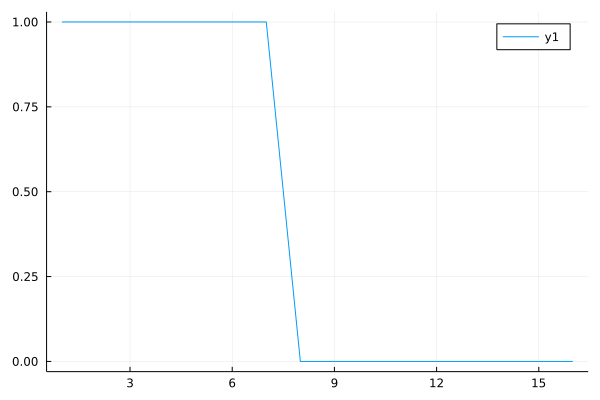

In [19]:
plot(1:16,norms[1:16])

As you can see, our algorithm computes a rigorous bound on the mixing time of the Markov chain Q; it is possible to observe the cutoff phenomena.

Let's see what happens if we take a finer partition.

In [20]:
B = Ulam(1024)
Q = DiscretizedOperator(B, D)
norms = powernormbounds(B, D; Q=Q)

32-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.7763568394002533e-14
 1.7763568394002533e-14
 1.7763568394002533e-14
 1.7763568394002533e-14
 ⋮
 3.1554436208840575e-28
 3.1554436208840575e-28
 3.1554436208840575e-28
 3.1554436208840575e-28
 3.1554436208840575e-28
 3.1554436208840575e-28
 3.1554436208840575e-28
 3.1554436208840575e-28
 3.1554436208840575e-28
 5.605193857299296e-42
 5.605193857299296e-42
 5.605193857299296e-42

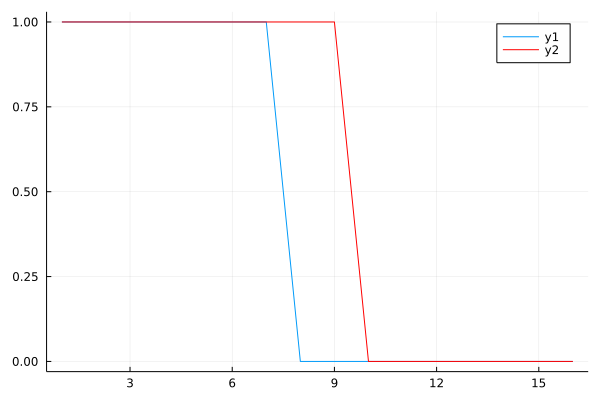

In [21]:
plot!(1:16,norms[1:16], color = :red)

As you can see, the mixing time of the Markov chain has grown as the size of the partition has grown. The spectral stability result of Liverani Keller guarantees that the mixing time grow as $\log(k)$, where $k$ is the size of the partition. 

In this case, a simple argument to show this is that if we take a partition of size $k = 2^N$ it takes $N$ iterates of the transfer operator for an element of the Ulam basis to cover all of $[0,1]$.

In [22]:
w = invariant_vector(B, Q)

1024-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [23]:
error = distance_from_invariant(B, D, Q, w, norms)

0.0

## An intuition of the coarse fine method

Now, I will try to give an intuitive idea behind how the coarse-fine method works.

In [24]:
v = zeros(1024);
v[1] = 1;

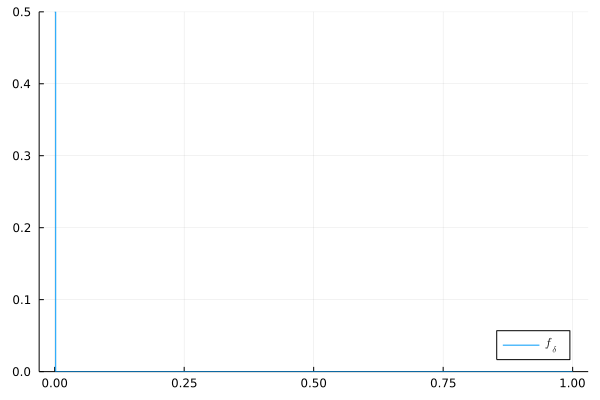

In [25]:
v = Q*v
plot(B, v)

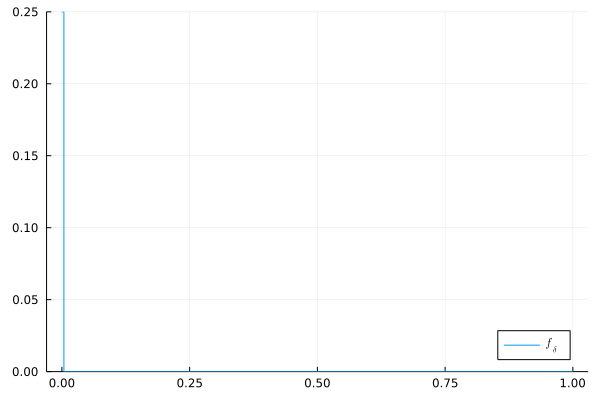

In [26]:
v = Q*v
plot(B, v)

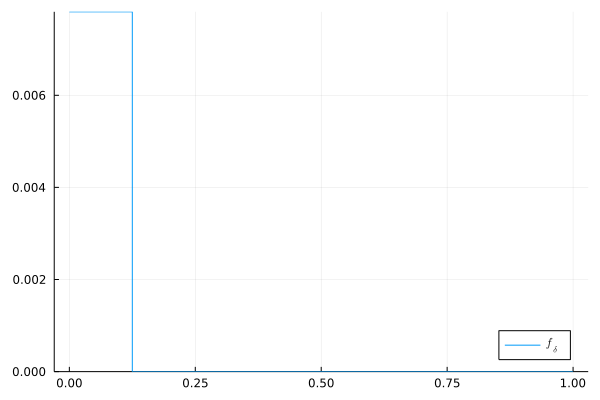

In [27]:
for i in 1:5
    v = Q*v
end
plot(B, v)

Under iterations of the system, the support of the vector $v$ becomes bigger, so it becomes visible to coarser discretizations.

The coarse operator and the fine operator satisfy the same Lasota-Yorke inequality and this guarantees that under iterations the variation of an observable is decreasing (up to some limit).

## A nonlinear example

We will now study the map from [O. Lanford, Informal remarks on the orbit structure of discrete approximations](https://projecteuclid.org/journals/experimental-mathematics/volume-7/issue-4/Informal-remarks-on-the-orbit-structure-of-discrete-approximations-to/em/1047674149.full) which is a beautiful article on computing orbits and the path method to compute Birkhoff averages.

In [28]:
D = mod1_dynamic(x->2*x+0.5*x*(1-x))

Piecewise-defined dynamic with 2 branches

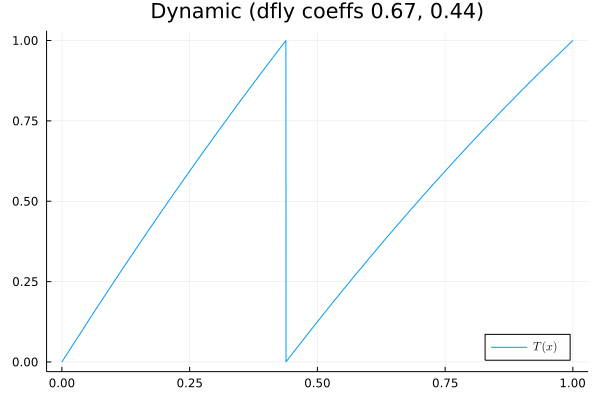

In [29]:
A, BB = dfly(strong_norm(B), aux_norm(B), D)
plot(D, title="Dynamic (dfly coeffs $(round(A, sigdigits=2)), $(round(BB, sigdigits=2)))", label=L"T(x)", legend=:bottomright)

In [30]:
B = Ulam(1024)
Q = DiscretizedOperator(B, D)

IntegralPreservingDiscretizedOperator{SparseArrays.SparseMatrixCSC{Interval{Float64}, Int64}}(sparse([1, 2, 3, 3, 4, 5, 5, 6, 7, 8  …  1018, 1019, 1020, 1020, 1021, 1021, 1022, 1023, 1023, 1024], [1, 1, 1, 2, 2, 2, 3, 3, 3, 3  …  1021, 1021, 1021, 1022, 1022, 1023, 1023, 1023, 1024, 1024], Interval{Float64}[[0.400031, 0.400032], [0.400093, 0.400094], [0.199874, 0.199875], [0.200281, 0.200282], [0.400218, 0.400219], [0.399499, 0.3995], [0.00078186, 0.000781861], [0.400344, 0.400345], [0.400406, 0.400407], [0.198467, 0.198468]  …  [0.00519481, 0.00519482], [0.66508, 0.665081], [0.329724, 0.329725], [0.335644, 0.335645], [0.664355, 0.664356], [0.00130039, 0.0013004], [0.665944, 0.665945], [0.332755, 0.332756], [0.333477, 0.333478], [0.666522, 0.666523]], 1024, 1024))

In [31]:
norms = powernormbounds(B, D; Q=Q)

64-element Vector{Float64}:
 1.0000000000002842
 1.0000000000005687
 1.000000000000853
 1.0000000000011375
 1.000000000001422
 1.0000000000017064
 1.0000000000019909
 1.0000000000022753
 1.0000000000025597
 1.0000000000028442
 1.0000000000031286
 1.000000000003413
 1.0000000000036975
 ⋮
 4.684052402620236e-7
 2.6920805816097756e-7
 1.5507419554679491e-7
 8.930935827896575e-8
 5.144562530750662e-8
 2.9628241928149067e-8
 1.71145223310598e-8
 9.886070031784808e-9
 5.71233389393418e-9
 3.2996850176696866e-9
 1.906856045636718e-9
 1.1013396810692148e-9

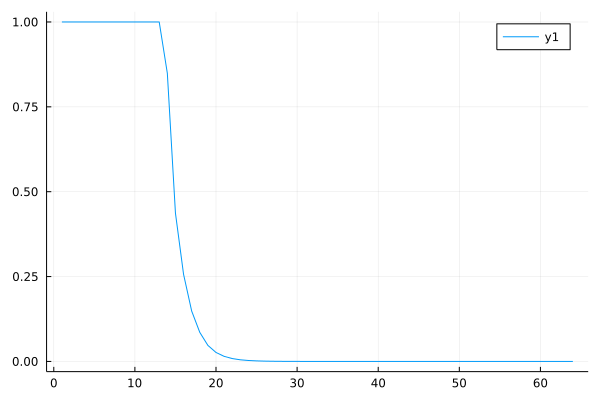

In [32]:
plot(norms)

In [33]:
w = invariant_vector(B, Q)

1024-element Vector{Float64}:
 0.7588622465973643
 0.7590272288837524
 0.7594493844614313
 0.7596679873914637
 0.7599670152475906
 0.7603210853993297
 0.7606863066031979
 0.7609512667060184
 0.7612901570497155
 0.7615053948886031
 0.7619896281633012
 0.7622610387652445
 0.7626203623334005
 ⋮
 1.3529134940734202
 1.3537453637230075
 1.3546701936294554
 1.3561326332980168
 1.3571595236101484
 1.3579847420493893
 1.359390530886165
 1.3603025904365698
 1.361369422841358
 1.3625763835481195
 1.363644565448264
 1.3643920636788023

In [34]:
error = distance_from_invariant(B, D, Q, w, norms)

0.04136823531234698

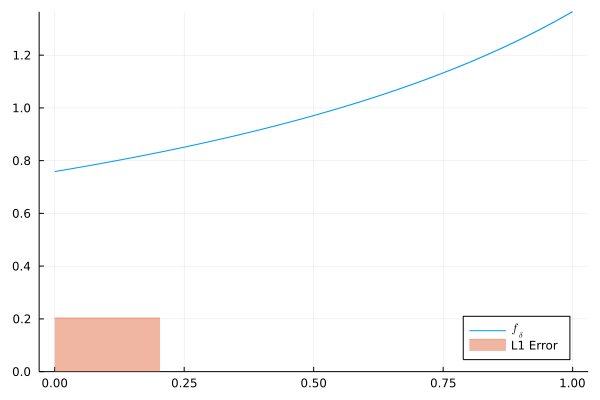

In [35]:
plot(B, w)
plot!(B, error)

We use now the coarse-fine strategy.

In [36]:
B_fine = Ulam(2^16)
Q_fine = DiscretizedOperator(B_fine, D)

IntegralPreservingDiscretizedOperator{SparseArrays.SparseMatrixCSC{Interval{Float64}, Int64}}(sparse([1, 2, 3, 3, 4, 5, 5, 6, 7, 8  …  65530, 65531, 65532, 65532, 65533, 65533, 65534, 65535, 65535, 65536], [1, 1, 1, 2, 2, 2, 3, 3, 3, 3  …  65533, 65533, 65533, 65534, 65534, 65535, 65535, 65535, 65536, 65536], Interval{Float64}[[0.4, 0.400001], [0.400001, 0.400002], [0.199998, 0.199999], [0.200004, 0.200005], [0.400003, 0.400004], [0.399992, 0.399993], [1.22071e-05, 1.22072e-05], [0.400005, 0.400006], [0.400006, 0.400007], [0.199976, 0.199977]  …  [8.13768e-05, 8.1377e-05], [0.666641, 0.666642], [0.333276, 0.333277], [0.333369, 0.33337], [0.66663, 0.666631], [2.03446e-05, 2.03447e-05], [0.666655, 0.666656], [0.333324, 0.333325], [0.333335, 0.333336], [0.666664, 0.666665]], 65536, 65536))

In [37]:
normQ_fine = opnormbound(B_fine, weak_norm(B_fine), Q_fine)
norms_fine = finepowernormbounds(B, B_fine, D, norms; normQ_fine=normQ_fine)
w_fine = invariant_vector(B_fine, Q_fine)
error_fine = distance_from_invariant(B_fine, D, Q_fine, w_fine, norms_fine)

0.0015197991036171386

In [38]:
plot(B_fine, w_fine)
plot!(B_fine, error_fine)

We can now compute rigorously the Lyapunov Exponent.

In [39]:
logder = discretizationlogder(B_fine, D)

Observable(Ulam{LinRange{Float64, Int64}}(range(0.0, stop=1.0, length=65537)), Interval{Float64}[[0.916287, 0.916288], [0.916281, 0.916282], [0.916275, 0.916276], [0.916269, 0.91627], [0.916263, 0.916264], [0.916257, 0.916258], [0.916251, 0.916252], [0.916244, 0.916245], [0.916238, 0.916239], [0.916232, 0.916233]  …  [0.405561, 0.405562], [0.405551, 0.405552], [0.405541, 0.405542], [0.405531, 0.405532], [0.405521, 0.405522], [0.40551, 0.405511], [0.4055, 0.405501], [0.40549, 0.405491], [0.40548, 0.405481], [0.40547, 0.405471]], [0.405465, 0.916291])

In [40]:
integrateobservable(B_fine, logder, w_fine, error_fine)

[0.656269, 0.659055]

I will show now the interface to the small-matrix method to estimate the speed of convergence in $BV$ of the original operator.

In [41]:
weak_bound, strong_bound = convergencerateabstract(B_fine, D, norms_fine)

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.11792639387388786, 0.1178123823705496, 0.1177346225493818, 0.11768233625786015, 0.11764778357278433, 0.11762548898931628, 0.1176116140930973, 0.11760349548546051, 0.11759929696762807, 0.11759775966774443], [1.1111111111111112, 0.8888888888888891, 0.7407407407407409, 0.6419753086419755, 0.5761316872427985, 0.5322359396433471, 0.47553726566072274, 0.4121322969059597, 0.3698623177361177, 0.3319277210452338  …  0.0022737804798869327, 0.002019559005980197, 0.0018124247489565868, 0.0016265350311148855, 0.0014597109253595127, 0.0012965070161848182, 0.0011635319376017599, 0.0010441953286169639, 0.0009370983718357368, 0.0008323254918717354])

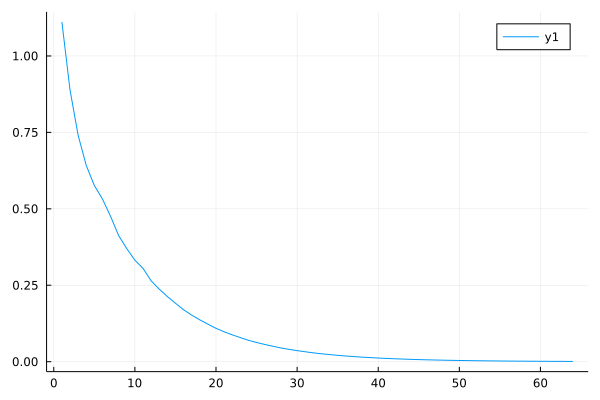

In [42]:
plot(strong_bound)

I will now apply the Gelfand formula for the spectral radius:
$$
\sqrt[n]{||L^n|_{V_0}||_{BV}}
$$
it is (still) not rigorous, but this could be used to get a lower bound for the spectral gap (the difference between $1$ and the modulus of the second eigenvalue) in BV for the abstract operator.

In [45]:
using IntervalArithmetic

In [46]:
1.0 .- [nthroot(Interval(strong_bound[i]), i) for i in 1:length(strong_bound)]

64-element Vector{Interval{Float64}}:
 [-0.111112, -0.111111]
  [0.0571909, 0.057191]
  [0.0951941, 0.0951942]
  [0.104883, 0.104884]
  [0.10442, 0.104421]
  [0.0997757, 0.0997758]
  [0.100743, 0.100744]
  [0.104883, 0.104884]
  [0.104626, 0.104627]
  [0.10442, 0.104421]
  [0.102251, 0.102252]
  [0.104883, 0.104884]
  [0.104705, 0.104706]
   ⋮
  [0.104839, 0.10484]
  [0.104797, 0.104798]
  [0.104757, 0.104758]
  [0.104883, 0.104884]
  [0.104842, 0.104843]
  [0.104803, 0.104804]
  [0.104765, 0.104766]
  [0.104883, 0.104884]
  [0.104845, 0.104846]
  [0.104808, 0.104809]
  [0.104773, 0.104774]
  [0.104883, 0.104884]

## Nonrigorous experiments: spectral stability

I would like to present now some numerical experiments on the spectral stability of the Ulam operator.
To do so, we will take different partition size and do a pseudospectral plot, plotting a numerical approximation of the spectrum and of the level lines of the resolvent.

In [47]:
import Pkg; Pkg.add("Pseudospectra")

   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [d6c5b33e] + Pseudospectra v0.2.0
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [48]:
using Pseudospectra, IntervalArithmetic

In [49]:
using IntervalArithmetic

Computing pseudospectra...  14%|██▊                 |  ETA: 0:00:07

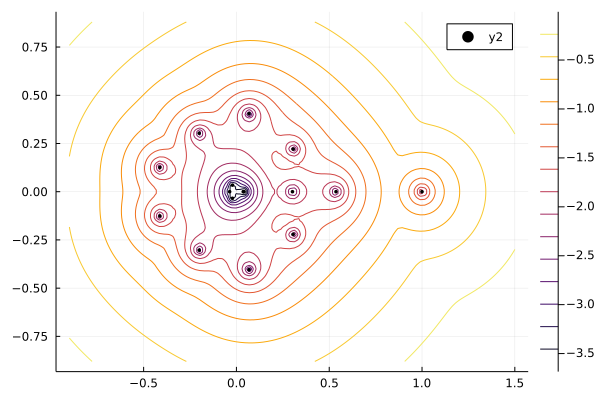

In [50]:
B = Ulam(16)
Q = DiscretizedOperator(B, D)
spectralportrait(Matrix(mid.(Q.L))) # the method is not defined for our DiscretizedOperators yet!!!
# so we take the matrix of the midpoints of Q

Computing pseudospectra... 100%|████████████████████| Time: 0:00:02


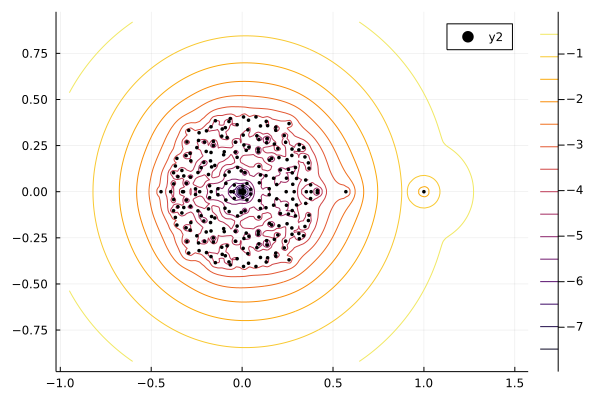

In [51]:
B = Ulam(256)
Q = DiscretizedOperator(B, D)
spectralportrait(Matrix(mid.(Q.L)))

Computing pseudospectra... 100%|████████████████████| Time: 0:01:03


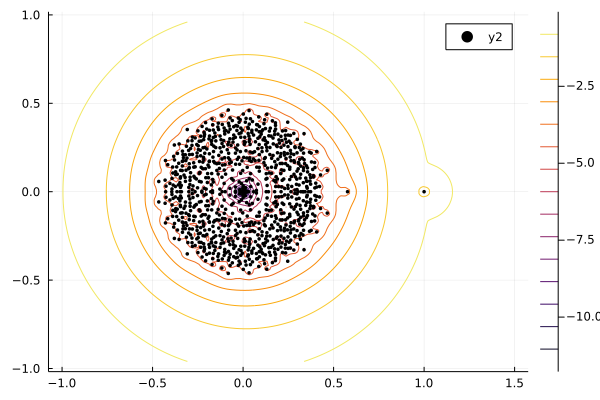

In [52]:
B = Ulam(1024)
Q = DiscretizedOperator(B, D)
spectralportrait(Matrix(mid.(Q.L)))

From these experiments is possible to see that while the spectrum of the operators is different, its structure is preserved.

## A Non-Markov example

Finally, I will show the same computation in an example which is non Markov.

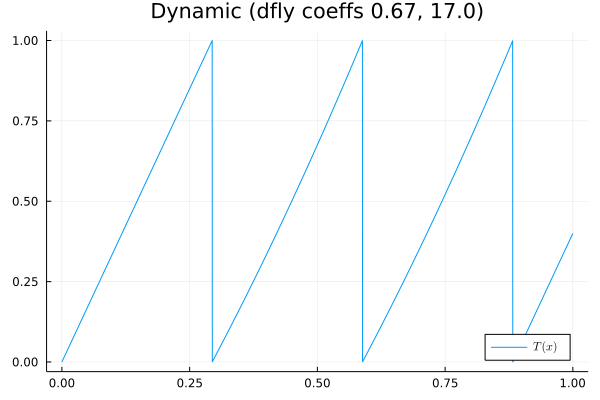

In [64]:
D = PwMap([x->17*x/5, 
	x->(34*((17*x-5)/17)/25+3)*((17*x-5)/17), 
	x->(34*((17*x-10)/17)/25+3)*((17*x-10)/17), 
	x->17*((17*x-15)/17)/5], 
	[Interval(0), Interval(5)/17, Interval(10)/17, Interval(15)/17, Interval(1)],
	[Interval(0) Interval(1);
	 Interval(0) Interval(1);
	 Interval(0) Interval(1);
	 Interval(0) @interval(0.4)]
	)
A, BB = dfly(strong_norm(B), aux_norm(B), D)
plot(D, title="Dynamic (dfly coeffs $(round(A, sigdigits=2)), $(round(BB, sigdigits=2)))", label=L"T(x)", legend=:bottomright)

In [65]:
B = Ulam(1024)
Q = DiscretizedOperator(B, D)

IntegralPreservingDiscretizedOperator{SparseArrays.SparseMatrixCSC{Interval{Float64}, Int64}}(sparse([1, 2, 3, 4, 4, 5, 6, 7, 7, 8  …  403, 403, 404, 405, 406, 407, 407, 408, 409, 410], [1, 1, 1, 1, 2, 2, 2, 2, 3, 3  …  1022, 1023, 1023, 1023, 1023, 1023, 1024, 1024, 1024, 1024], Interval{Float64}[[0.294117, 0.294118], [0.294117, 0.294118], [0.294117, 0.294118], [0.117647, 0.117648], [0.17647, 0.176471], [0.294117, 0.294118], [0.294117, 0.294118], [0.235294, 0.235295], [0.0588235, 0.0588236], [0.294117, 0.294118]  …  [0.235294, 0.235295], [0.0588235, 0.0588236], [0.294117, 0.294118], [0.294117, 0.294118], [0.294117, 0.294118], [0.0588235, 0.0588236], [0.235294, 0.235295], [0.294117, 0.294118], [0.294117, 0.294118], [0.17647, 0.176471]], 1024, 1024))

In [66]:
norms = powernormbounds(B, D; Q=Q)

64-element Vector{Float64}:
 1.0000000000013642
 1.0000000000027287
 1.0000000000040932
 1.0000000000054576
 1.000000000006822
 0.6915384961496334
 0.14623881724703963
 0.049931638230565775
 0.049931638230633894
 0.04993163823070201
 0.04993163823077013
 0.04993163823083825
 0.04993163823090637
 ⋮
 1.549725900937208e-8
 6.637498074766228e-9
 2.2663008280861432e-9
 7.738035304160647e-10
 7.738035304171203e-10
 7.73803530418176e-10
 7.738035304192316e-10
 7.738035304202872e-10
 7.738035304213429e-10
 3.314211526253041e-10
 1.1316011306962894e-10
 3.863727794226954e-11

In [67]:
B_fine = Ulam(2^16)
Q_fine = DiscretizedOperator(B_fine, D)

Computing preimages... 100%|█████████████████████████████| Time: 0:00:01


IntegralPreservingDiscretizedOperator{SparseArrays.SparseMatrixCSC{Interval{Float64}, Int64}}(sparse([1, 2, 3, 4, 4, 5, 6, 7, 7, 8  …  26208, 26209, 26210, 26211, 26212, 26211, 26212, 26213, 26214, 26215], [1, 1, 1, 1, 2, 2, 2, 2, 3, 3  …  65535, 65535, 65535, 65535, 65535, 65536, 65536, 65536, 65536, 65536], Interval{Float64}[[0.294117, 0.294118], [0.294117, 0.294118], [0.294117, 0.294118], [0.117647, 0.117648], [0.17647, 0.176471], [0.294117, 0.294118], [0.294117, 0.294118], [0.235294, 0.235295], [0.0588235, 0.0588236], [0.294117, 0.294118]  …  [0.117647, 0.117648], [0.294117, 0.294118], [0.294117, 0.294118], [0.294117, 0.294118], [0, 7.27596e-12], [0, 7.27596e-12], [0.294117, 0.294118], [0.294117, 0.294118], [0.294117, 0.294118], [0.117647, 0.117648]], 65536, 65536))

In [70]:
normQ_fine = opnormbound(B_fine, weak_norm(B_fine), Q_fine)
norms_fine = finepowernormbounds(B, B_fine, D, norms; normQ_fine=normQ_fine)
w_fine = invariant_vector(B_fine, Q_fine)
error_fine = distance_from_invariant(B_fine, D, Q_fine, w_fine, norms_fine)

0.2334659976204818

In [71]:
plot(B_fine, w_fine)
plot!(B_fine, error_fine)

In [72]:
logder = discretizationlogder(B_fine, D)
integrateobservable(B_fine, logder, w_fine, error_fine)

[0.908069, 1.53143]

# Summary of this lecture

In this lecture I showed how to use our package to rigorously approximate the Ulam operator on a partition, how to use our package to compute the norms of this discretized operator on the space of average $0$ functions and how to use the coarse-fine approach to get estimates on the mixing time of finer operators.

This allows us to rigorously approximate the invariant density of the system, and through rigorous integration to compute the Lyapunov exponent and the Birkhoff averages of an observable with a rigorous error bound.